In [2]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro']


In [9]:
# Load the B30 Pro sheet
b30_pro = pd.read_excel(xls, sheet_name="B30 Pro")

In [ ]:
# Display size of the data
print(f"B30 Pro Shape: {b30_pro.shape}")

B30 Pro Shape: (3142, 19)


In [12]:
# Display basic info about the data
print(b30_pro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   model                      3142 non-null   object 
 1   sim_info                   3142 non-null   object 
 2   register_email             3142 non-null   bool   
 3   interval_date              3142 non-null   object 
 4   last_boot_date             3142 non-null   object 
 5   active_date                3142 non-null   object 
 6   last boot - interval       3142 non-null   float64
 7   last boot - active         3142 non-null   float64
 8   return - activate          3142 non-null   float64
 9   Return date                3142 non-null   object 
 10  Channel                    3142 non-null   object 
 11  Type                       3142 non-null   object 
 12  Warranty                   3142 non-null   object 
 13  Analysis and Verification  3142 non-null   objec

In [32]:
print(b30_pro.describe())

       last boot - interval  last boot - active  return - activate  \
count           3142.000000         3142.000000        3142.000000   
mean              -4.853672           55.360902           0.299003   
std               16.745229           45.875921           3.596243   
min             -113.939317            0.000000         -10.614734   
25%               -9.345191           10.964641           0.000000   
50%               -2.096493           43.406701           0.000000   
75%                0.238093          103.791024           0.000000   
max              113.381921          139.369063          99.806806   

        Churn Flag  
count  3142.000000  
mean      0.022279  
std       0.147612  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  


In [ ]:
# check for missing values
print(f"Missing Values:\n{b30_pro.isnull().sum()}")

Missing Values:
model                        0
sim_info                     0
register_email               0
interval_date                0
last_boot_date               0
active_date                  0
last boot - interval         0
last boot - active           0
return - activate            0
Return date                  0
Channel                      0
Type                         0
Warranty                     0
Analysis and Verification    0
Defect / Damage type         0
Responsible Party            0
Spare Parts Usage            0
Final Status                 0
Churn Flag                   0
dtype: int64


In [14]:
# check for duplicates
duplicates = b30_pro.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


Churn Flag Distribution:
Churn Flag
0    3072
1      70
Name: count, dtype: int64


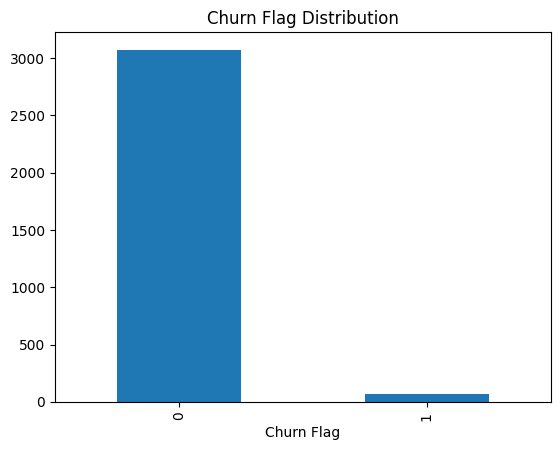

In [15]:
# visualize the distribution of the 'Churn Flag' => check for class imbalance
if 'Churn Flag' in b30_pro.columns:
    churn_counts = b30_pro['Churn Flag'].value_counts()
    print(f"Churn Flag Distribution:\n{churn_counts}")
    churn_counts.plot(kind='bar', title='Churn Flag Distribution')
    plt.show()

This shows that the distribution of the "Churn Flag" column is imbalanced!
Note: We only know that those with churn flag = 1 are confirmed returns, we need to predict whether those with churn flag = 0 are returns or not returns.

In [ ]:
# Separate churned and non-churned records
churned = b30_pro[b30_pro['Churn Flag'] == 1]
non_churned = b30_pro[b30_pro['Churn Flag'] == 0]

# Plot the distribution of a feature for churned vs non-churned customers
def plot_feature_distribution(data, feature, churned_data, non_churned_data):
    # Plot the distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(churned_data[feature], color='red', label='Churned', kde=True, stat='density', bins=30)
    sns.histplot(non_churned_data[feature], color='blue', label='Non-Churned', kde=True, stat='density', bins=30)
    plt.title(f'Distribution of {feature}: Churned vs Non-Churned')
    plt.legend()
    plt.show()

In [ ]:
# List of numerical features (seen from the data info)
numerical_features = ['last boot - interval', 'last boot - active', 'return - activate']

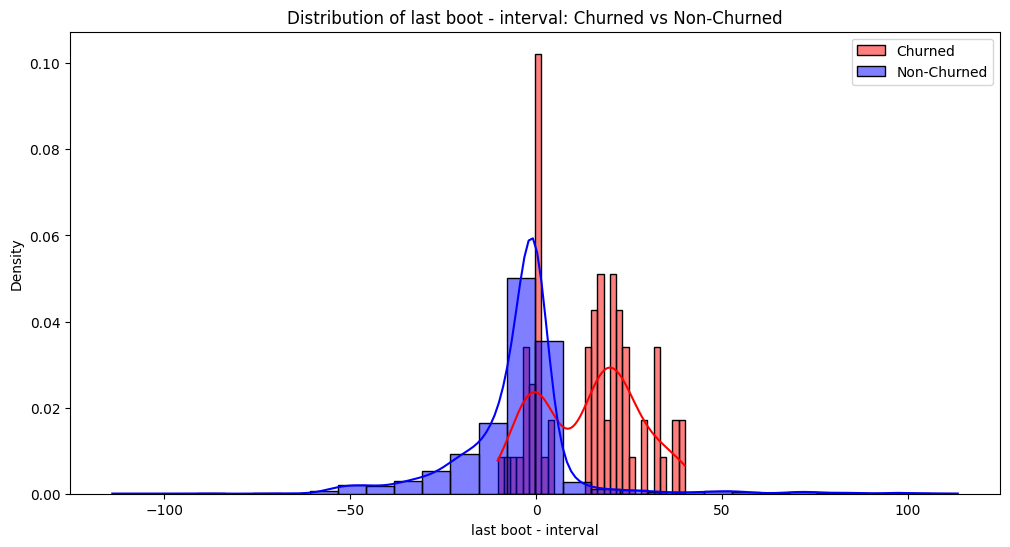

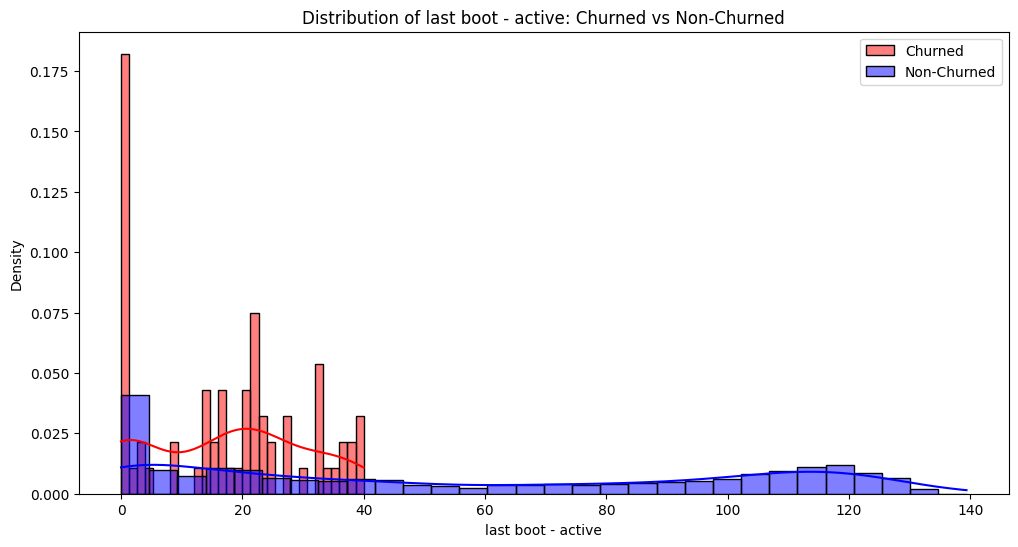

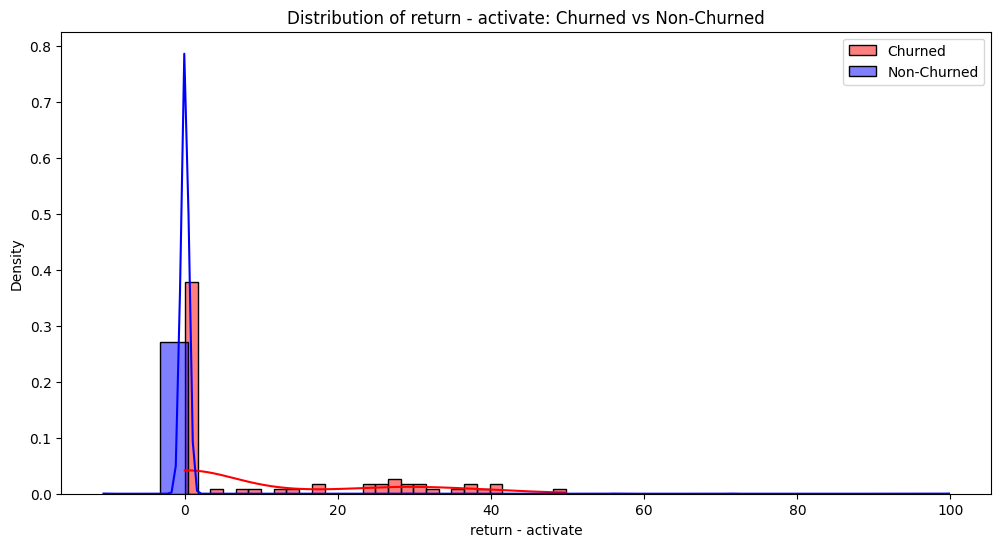

In [29]:
# Loop through each numerical feature and plot the distribution
for feature in numerical_features:
    plot_feature_distribution(b30_pro, feature, churned, non_churned)

In [ ]:
# conduct T-test on the numerical features
for feature in numerical_features:
    t_stat, p_val = stats.ttest_ind(churned[feature], non_churned[feature], equal_var=False)
    print(f"T-test for '{feature}' p-value: {p_val}")

T-test for 'last boot - interval' p-value: 3.5534948409265625e-19
T-test for 'last boot - active' p-value: 7.625494852891254e-43
T-test for 'return - activate' p-value: 3.692385468617318e-07


T-test: a statistical test used to compare the means of two groups to determine if they are significantly different from each other

From the T-tests, we can see that all of them are extremely small, which means that there is significant difference between churned & non-churned customers

In [35]:
# Conduct effect size analysis using Cohen's d
def cohen_d(x1, x2):
    return (x1.mean() - x2.mean()) / ((x1.std() ** 2 + x2.std() ** 2) / 2) ** 0.5

for feature in numerical_features:
    d_value = cohen_d(churned[feature], non_churned[feature])
    print(f"Cohen’s d for '{feature}': {d_value}")

Cohen’s d for 'last boot - interval': 1.2957851367769138
Cohen’s d for 'last boot - active': -1.1533269328491587
Cohen’s d for 'return - activate': 0.9372115045655316


Cohen's d calculates the effect size/magnitude of the difference between the churned & non-churned customers for each feature.

last_boot_bin
(-113.94, -9.345]    0.001272
(-9.345, -2.096]     0.005096
(-2.096, 0.238]      0.017834
(0.238, 113.382]     0.064885
Name: Churn Flag, dtype: float64


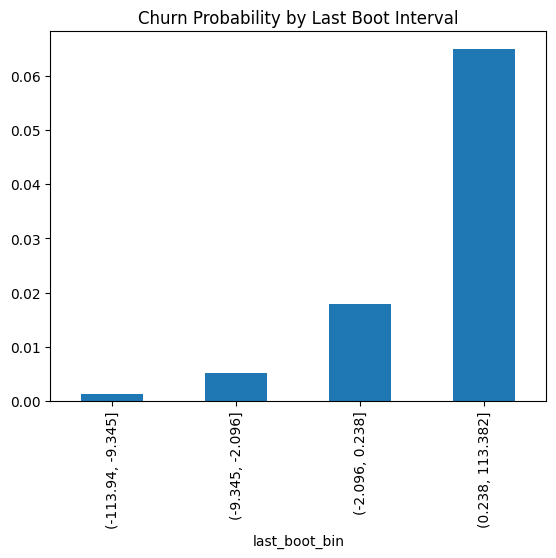

In [39]:
# Bin 'last boot interval' into quartiles
b30_pro['last_boot_bin'] = pd.qcut(b30_pro['last boot - interval'], q=4)

# Churn rate by bin of 'last boot interval', with observed=True to avoid the warning
churn_rate_by_bin = b30_pro.groupby('last_boot_bin', observed=True)['Churn Flag'].mean()
print(churn_rate_by_bin)

# Plot the churn rate by bin
churn_rate_by_bin.plot(kind='bar', title='Churn Probability by Last Boot Interval')
plt.show()

- As the last boot interval increases (increasing from negative to positive values), the churn probability also seems to increase.
- Hypothesis: The pattern suggests that users who have a longer time between boot events might be more likely to churn

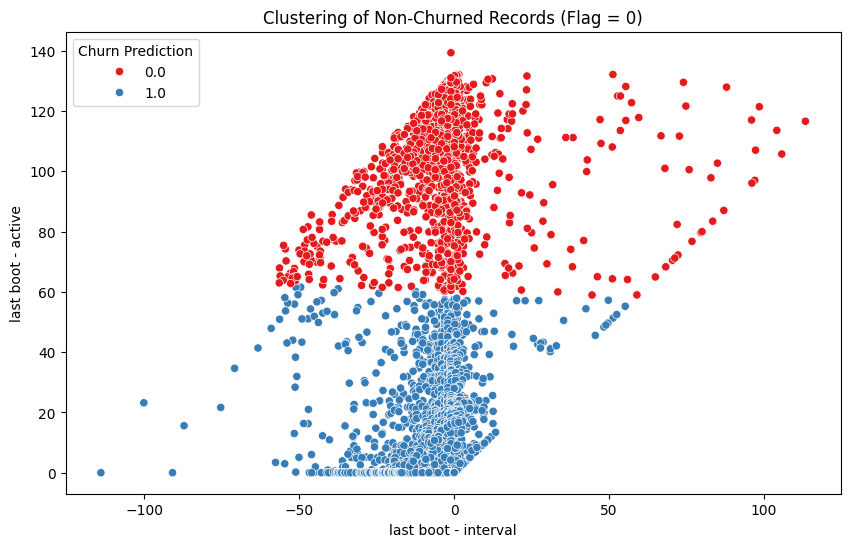

In [38]:
from sklearn.cluster import KMeans # pip install scikit-learn

# Select the numerical features for clustering
features_for_clustering = b30_pro[b30_pro['Churn Flag'] == 0][numerical_features]

# Apply KMeans clustering (e.g., 2 clusters for simplicity)
kmeans = KMeans(n_clusters=2, random_state=42)
b30_pro.loc[b30_pro['Churn Flag'] == 0, 'Churn Prediction'] = kmeans.fit_predict(features_for_clustering)

# Plot the clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=b30_pro[b30_pro['Churn Flag'] == 0], x='last boot - interval', y='last boot - active', hue='Churn Prediction', palette='Set1')
plt.title("Clustering of Non-Churned Records (Flag = 0)")
plt.show()